<a href="https://colab.research.google.com/github/mehrnazeraeisi/Jannis/blob/main/Jannis_43977.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#   مشاهده نمودارها برای هر درصد دلخواه
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def evaluate_knn_on_dataset(X_data, y_data, test_size=0.2, n_repeats=20):
    # مرحله 1: محاسبه Accuracy برای تک‌ویژگی‌ها
    def compute_acc_per_feature(X, y):
        feature_scores = []
        for feature in X.columns:
            model = KNeighborsClassifier()
            model.fit(X[[feature]], y)
            y_pred = model.predict(X[[feature]])
            acc=accuracy_score(y, y_pred)
            feature_scores.append((feature, acc))
        df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
        return df_scores.sort_values(by='Accuracy', ascending=False)

    # مرحله 2: بررسی گروه‌های افزایشی ویژگی‌ها
    def evaluate_incremental_feature_groups(X, y, sorted_features):
        results = []
        best_acc = -np.inf
        best_group = []
        for k in range(1, len(sorted_features) + 1):
            group = sorted_features[:k]
            model = KNeighborsClassifier()
            model.fit(X[group], y)
            y_pred = model.predict(X[group])
            acc=accuracy_score(y, y_pred)
            results.append((k, acc))
            if acc > best_acc:
                best_acc = acc
                best_group = group
        # اضافه کردن All Features به لیست
        model.fit(X, y)
        y_pred = model.predict(X)
        all_acc = accuracy_score(y, y_pred)
        results.append(("All Features", all_acc))
        return pd.DataFrame(results, columns=["Group Size", "Accuracy"]), best_group

    # اجرای مراحل
    single_feat_df = compute_acc_per_feature(X_data, y_data)
    sorted_features = single_feat_df['Feature'].tolist()
    group_results_df, best_group = evaluate_incremental_feature_groups(X_data, y_data, sorted_features)

    # مرحله 3: چاپ نتایج اولیه
    print("📌 نتایج Accuracy برای هر ویژگی:")
    print(single_feat_df.to_string(index=False))

    print("\n📊 نتایج عملکرد گروه‌های افزایشی Accuracy:")
    print(group_results_df.to_string(index=False))

    best_acc = group_results_df[group_results_df["Group Size"] == len(best_group)]["Accuracy"].values[0]

    print("\n🏆 بهترین گروه:")
    print(f"📌 تعداد ویژگی‌ها: {len(best_group)}")
    print(f"🔹 Accuracy: {best_acc:.4f}")

    # مرحله 4: ارزیابی نهایی با Split و رسم نمودار
    acc_scores = {"all_features": [], "best_group": []}

    feature_groups = {
        "all_features": X_data.columns.tolist(),
        "best_group": best_group
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)
        for group_name, group_features in feature_groups.items():
            model = KNeighborsClassifier()
            model.fit(X_train[group_features], y_train)
            y_pred = model.predict(X_test[group_features])
            acc_scores[group_name].append(accuracy_score(y_test, y_pred))

    # رسم نمودار Accuracy
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for name, acc in acc_scores.items():
        plt.plot(x, acc, label=f"{name.replace('_', ' ').title()} Accuracy", marker='o')
    plt.xlabel("Repeat")
    plt.ylabel("Accuracy")
    plt.title("KNN Classifier Accuracy Performance")
    plt.legend()
    plt.grid(True)
    plt.show()


    # چاپ نتایج نهایی میانگین
    print("\n📈 میانگین نتایج پس از تکرار:")
    for name in feature_groups:
        avg_acc = np.mean(acc_scores[name])
        print(f"{name.replace('_', ' ').title()} → Accuracy: {avg_acc:.4f}")


In [2]:
!pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.7 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=bdad0d319a7c9fb3144688a48d9ffa96f5f24f56b2372d292878342521592f03
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [3]:
#echocardiogram-uci
#
import openml
import pandas as pd

# دانلود دیتاست
dataset = openml.datasets.get_dataset(43977)
data, y_data, _, _ = dataset.get_data(target=dataset.default_target_attribute)
print(data.shape)
# افزودن ستون هدف به دیتافریم کامل
data['rating'] = y_data  # فرض بر این است که ستون هدف، rating است

print("قبل از حذف NaN و ستون:", data.shape)

# حذف سطرهای دارای NaN
data = data.dropna()

# حذف ستون خاص (در صورت وجود آن)
if 'Accident_Index' in data.columns:
    data = data.drop('Accident_Index', axis=1)
    print("ستون Accident_Index حذف شد.")

# بررسی ستون‌ها و شکل نهایی
print(data.columns)
print(data.head())
print("بعد از حذف:", data.shape)

# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('rating', axis=1)
y_data = data['rating']

print(X_data.head() )  # ویژگی‌ها
print(f"\nهدف")
print(y_data.head())
print(f"\nسایز دیتاست")
print(X_data.shape)



(57580, 54)
قبل از حذف NaN و ستون: (57580, 55)
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41',
       'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'rating'],
      dtype='object')
         V1        V2        V3        V4        V5        V6        V7  \
0  0.067448  0.270833  0.444444  0.903230  0.455349  0.220512  0.343834   
1  0.078258  0.218750  0.602778  0.070734  0.332808  0.158481  0.597466   
2  0.045457  0.304167  0.286111  0.688610  0.575015  0.247521  0.197057   
3  0.162303  1.000000  0.168750  0.504051  0.082256  0.994265  0.162670   
4  0.024902  0.272917  0.171875  0.092023  0.063230  0.226857  0.153687   

         V8        V9       V10  ...       V46       V47  

📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
    V22  0.736089
     V6  0.731313
    V20  0.729142
    V15  0.728482
    V14  0.728100
    V23  0.726641
    V13  0.722213
    V12  0.718948
    V21  0.715335
     V1  0.714154
    V19  0.710577
    V11  0.710542
    V24  0.703248
     V5  0.702258
     V8  0.702206
    V18  0.702101
    V26  0.701563
     V4  0.697864
    V10  0.697516
    V25  0.695623
    V27  0.695224
    V17  0.693505
    V16  0.691039
    V34  0.690691
     V7  0.690413
     V9  0.690379
    V51  0.688954
    V33  0.688677
    V47  0.688659
    V48  0.688538
    V50  0.688364
    V28  0.688242
    V40  0.688138
    V32  0.687912
    V41  0.687826
    V39  0.687582
    V44  0.687565
    V36  0.687322
    V42  0.687235
    V43  0.687166
    V37  0.687166
    V52  0.687148
    V46  0.686957
    V49  0.686714
    V53  0.686558
    V30  0.686210
    V45  0.686141
    V35  0.686141
    V54  0.685846
    V31  0.683293
     V2  0.506582
     V3  0.503908
    V38  0.502

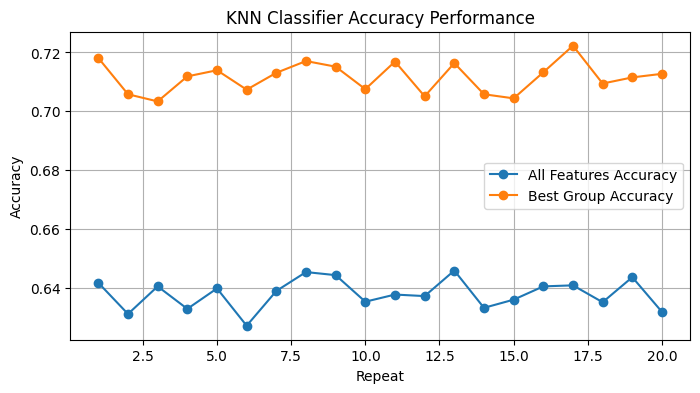


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.6379
Best Group → Accuracy: 0.7116


In [4]:
# اجرای ارزیابی مدل (تابع فرضی شما)
evaluate_knn_on_dataset(X_data, y_data, test_size=0.1, n_repeats=20)

📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
    V22  0.736089
     V6  0.731313
    V20  0.729142
    V15  0.728482
    V14  0.728100
    V23  0.726641
    V13  0.722213
    V12  0.718948
    V21  0.715335
     V1  0.714154
    V19  0.710577
    V11  0.710542
    V24  0.703248
     V5  0.702258
     V8  0.702206
    V18  0.702101
    V26  0.701563
     V4  0.697864
    V10  0.697516
    V25  0.695623
    V27  0.695224
    V17  0.693505
    V16  0.691039
    V34  0.690691
     V7  0.690413
     V9  0.690379
    V51  0.688954
    V33  0.688677
    V47  0.688659
    V48  0.688538
    V50  0.688364
    V28  0.688242
    V40  0.688138
    V32  0.687912
    V41  0.687826
    V39  0.687582
    V44  0.687565
    V36  0.687322
    V42  0.687235
    V43  0.687166
    V37  0.687166
    V52  0.687148
    V46  0.686957
    V49  0.686714
    V53  0.686558
    V30  0.686210
    V45  0.686141
    V35  0.686141
    V54  0.685846
    V31  0.683293
     V2  0.506582
     V3  0.503908
    V38  0.502

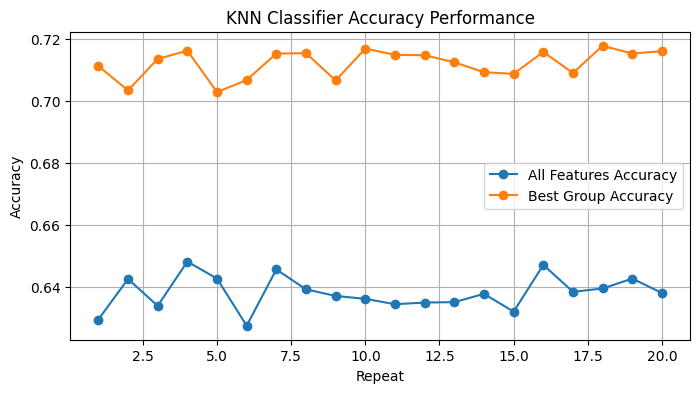


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.6381
Best Group → Accuracy: 0.7122


In [5]:
# اجرای ارزیابی مدل (تابع فرضی شما)
evaluate_knn_on_dataset(X_data, y_data, test_size=0.13, n_repeats=20)

📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
    V22  0.736089
     V6  0.731313
    V20  0.729142
    V15  0.728482
    V14  0.728100
    V23  0.726641
    V13  0.722213
    V12  0.718948
    V21  0.715335
     V1  0.714154
    V19  0.710577
    V11  0.710542
    V24  0.703248
     V5  0.702258
     V8  0.702206
    V18  0.702101
    V26  0.701563
     V4  0.697864
    V10  0.697516
    V25  0.695623
    V27  0.695224
    V17  0.693505
    V16  0.691039
    V34  0.690691
     V7  0.690413
     V9  0.690379
    V51  0.688954
    V33  0.688677
    V47  0.688659
    V48  0.688538
    V50  0.688364
    V28  0.688242
    V40  0.688138
    V32  0.687912
    V41  0.687826
    V39  0.687582
    V44  0.687565
    V36  0.687322
    V42  0.687235
    V43  0.687166
    V37  0.687166
    V52  0.687148
    V46  0.686957
    V49  0.686714
    V53  0.686558
    V30  0.686210
    V45  0.686141
    V35  0.686141
    V54  0.685846
    V31  0.683293
     V2  0.506582
     V3  0.503908
    V38  0.502

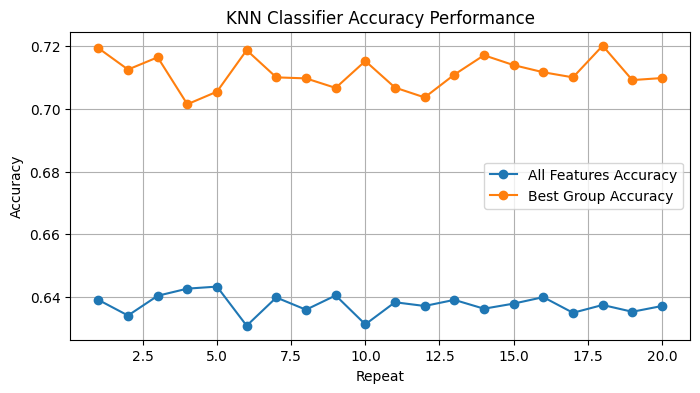


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.6376
Best Group → Accuracy: 0.7115


In [6]:
# اجرای ارزیابی مدل (تابع فرضی شما)
evaluate_knn_on_dataset(X_data, y_data, test_size=0.16, n_repeats=20)

📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
    V22  0.736089
     V6  0.731313
    V20  0.729142
    V15  0.728482
    V14  0.728100
    V23  0.726641
    V13  0.722213
    V12  0.718948
    V21  0.715335
     V1  0.714154
    V19  0.710577
    V11  0.710542
    V24  0.703248
     V5  0.702258
     V8  0.702206
    V18  0.702101
    V26  0.701563
     V4  0.697864
    V10  0.697516
    V25  0.695623
    V27  0.695224
    V17  0.693505
    V16  0.691039
    V34  0.690691
     V7  0.690413
     V9  0.690379
    V51  0.688954
    V33  0.688677
    V47  0.688659
    V48  0.688538
    V50  0.688364
    V28  0.688242
    V40  0.688138
    V32  0.687912
    V41  0.687826
    V39  0.687582
    V44  0.687565
    V36  0.687322
    V42  0.687235
    V43  0.687166
    V37  0.687166
    V52  0.687148
    V46  0.686957
    V49  0.686714
    V53  0.686558
    V30  0.686210
    V45  0.686141
    V35  0.686141
    V54  0.685846
    V31  0.683293
     V2  0.506582
     V3  0.503908
    V38  0.502

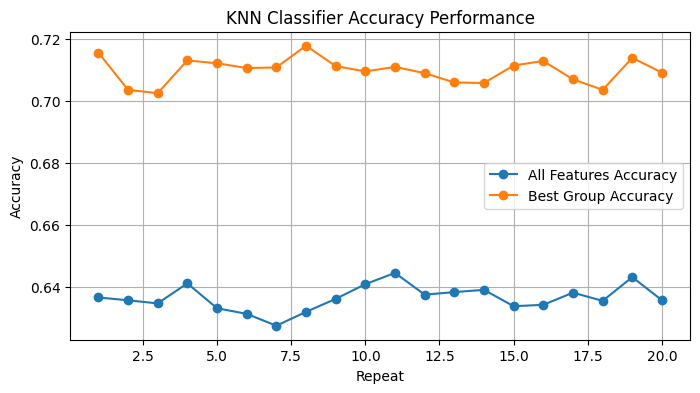


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.6364
Best Group → Accuracy: 0.7099


In [7]:
# اجرای ارزیابی مدل (تابع فرضی شما)
evaluate_knn_on_dataset(X_data, y_data, test_size=0.19, n_repeats=20)

📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
    V22  0.736089
     V6  0.731313
    V20  0.729142
    V15  0.728482
    V14  0.728100
    V23  0.726641
    V13  0.722213
    V12  0.718948
    V21  0.715335
     V1  0.714154
    V19  0.710577
    V11  0.710542
    V24  0.703248
     V5  0.702258
     V8  0.702206
    V18  0.702101
    V26  0.701563
     V4  0.697864
    V10  0.697516
    V25  0.695623
    V27  0.695224
    V17  0.693505
    V16  0.691039
    V34  0.690691
     V7  0.690413
     V9  0.690379
    V51  0.688954
    V33  0.688677
    V47  0.688659
    V48  0.688538
    V50  0.688364
    V28  0.688242
    V40  0.688138
    V32  0.687912
    V41  0.687826
    V39  0.687582
    V44  0.687565
    V36  0.687322
    V42  0.687235
    V43  0.687166
    V37  0.687166
    V52  0.687148
    V46  0.686957
    V49  0.686714
    V53  0.686558
    V30  0.686210
    V45  0.686141
    V35  0.686141
    V54  0.685846
    V31  0.683293
     V2  0.506582
     V3  0.503908
    V38  0.502

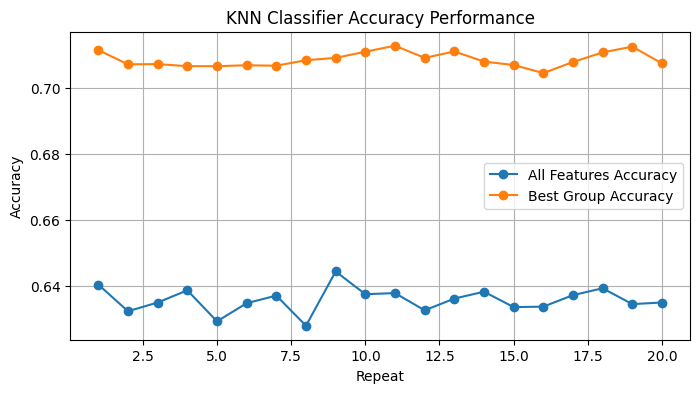


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.6359
Best Group → Accuracy: 0.7085


In [8]:
# اجرای ارزیابی مدل (تابع فرضی شما)
evaluate_knn_on_dataset(X_data, y_data, test_size=0.25, n_repeats=20)

📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
    V22  0.736089
     V6  0.731313
    V20  0.729142
    V15  0.728482
    V14  0.728100
    V23  0.726641
    V13  0.722213
    V12  0.718948
    V21  0.715335
     V1  0.714154
    V19  0.710577
    V11  0.710542
    V24  0.703248
     V5  0.702258
     V8  0.702206
    V18  0.702101
    V26  0.701563
     V4  0.697864
    V10  0.697516
    V25  0.695623
    V27  0.695224
    V17  0.693505
    V16  0.691039
    V34  0.690691
     V7  0.690413
     V9  0.690379
    V51  0.688954
    V33  0.688677
    V47  0.688659
    V48  0.688538
    V50  0.688364
    V28  0.688242
    V40  0.688138
    V32  0.687912
    V41  0.687826
    V39  0.687582
    V44  0.687565
    V36  0.687322
    V42  0.687235
    V43  0.687166
    V37  0.687166
    V52  0.687148
    V46  0.686957
    V49  0.686714
    V53  0.686558
    V30  0.686210
    V45  0.686141
    V35  0.686141
    V54  0.685846
    V31  0.683293
     V2  0.506582
     V3  0.503908
    V38  0.502

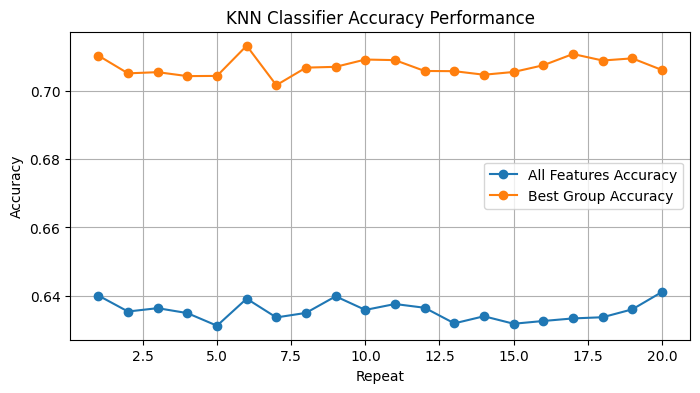


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.6355
Best Group → Accuracy: 0.7072


In [9]:
# اجرای ارزیابی مدل (تابع فرضی شما)
evaluate_knn_on_dataset(X_data, y_data, test_size=0.30, n_repeats=20)

In [10]:
def knn_classification_results_table_from_xy(X_data, y_data, test_sizes=[0.1, 0.13, 0.16, 0.19, 0.25], n_repeats=20):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import pandas as pd
    import numpy as np

    feature_names = X_data.columns.tolist()

    # مرحله 1: محاسبه دقت (Accuracy) برای هر ویژگی
    scores = []
    for feature in feature_names:
        model = KNeighborsClassifier()
        model.fit(X_data[[feature]], y_data)
        y_pred = model.predict(X_data[[feature]])
        acc = accuracy_score(y_data, y_pred)
        scores.append((feature, acc))

    df_scores = pd.DataFrame(scores, columns=['Feature', 'Accuracy']).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

    # مرحله 2: یافتن بهترین گروه ویژگی‌ها
    best_acc = -np.inf
    best_group = []
    for k in range(1, len(df_scores) + 1):
        group = df_scores['Feature'][:k].tolist()
        model = KNeighborsClassifier()
        model.fit(X_data[group], y_data)
        y_pred = model.predict(X_data[group])
        acc = accuracy_score(y_data, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_group = group

    # مرحله 3: اجرای آزمایش روی چند test size و تکرار
    detailed_results = []
    for ts in test_sizes:
        for repeat in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=ts)

            # مدل روی همه ویژگی‌ها
            model_all = KNeighborsClassifier()
            model_all.fit(X_train, y_train)
            y_pred_all = model_all.predict(X_test)
            acc_all = accuracy_score(y_test, y_pred_all)

            # مدل روی گروه ویژگی‌های منتخب
            model_best = KNeighborsClassifier()
            model_best.fit(X_train[best_group], y_train)
            y_pred_best = model_best.predict(X_test[best_group])
            acc_best = accuracy_score(y_test, y_pred_best)

            # ذخیره در جدول نتایج
            detailed_results.append({
                'Test Size': ts,
                'Repeat': repeat,
                'All_Accuracy': acc_all,
                'Best_Accuracy': acc_best
            })

    return pd.DataFrame(detailed_results)


In [11]:

# Climate Model Simulation
# شبیه‌سازی آب‌وهوا (دوتایی)
import openml
import pandas as pd

dataset = openml.datasets.get_dataset(40966)
data, y_data, _, _ = dataset.get_data(target=dataset.default_target_attribute)

data['rating'] = y_data


print(data.shape)
# حذف سطرهای حاوی NaN
data = data.dropna()
print(data.shape)


# 🎯 جدا کردن ویژگی‌ها و برچسب‌ها (مطابق ساختار شما)
X = data.drop('rating', axis=1)
y = data['rating']

# اجرای تابع جدول
df_result = knn_classification_results_table_from_xy(X, y)
print(df_result)


(1080, 78)
(552, 78)
    Test Size  Repeat  All_Accuracy  Best_Accuracy
0        0.10       1      0.910714       0.982143
1        0.10       2      0.946429       1.000000
2        0.10       3      0.964286       0.982143
3        0.10       4      0.946429       1.000000
4        0.10       5      0.982143       1.000000
..        ...     ...           ...            ...
95       0.25      16      0.913043       0.949275
96       0.25      17      0.905797       0.949275
97       0.25      18      0.920290       0.963768
98       0.25      19      0.913043       0.956522
99       0.25      20      0.927536       0.971014

[100 rows x 4 columns]
